In [1]:
# 예제 9.18 : BSD500 데이터세트 불러오기
import tensorflow as tf

tf.keras.utils.get_file("/content/bsd_images.zip", 'http://bit.ly/35pHZlC', extract = True)


!unzip /content/bsd_images.zip

37527552/37520292 [==============================] - 0s 0us/step
Archive:  /content/bsd_images.zip
   creating: images/
   creating: images/test/
  inflating: images/test/100007.jpg  
  inflating: images/test/100039.jpg  
  inflating: images/test/100099.jpg  
  inflating: images/test/10081.jpg   
  inflating: images/test/101027.jpg  
  inflating: images/test/101084.jpg  
  inflating: images/test/102062.jpg  
  inflating: images/test/103006.jpg  
  inflating: images/test/103029.jpg  
  inflating: images/test/103078.jpg  
  inflating: images/test/104010.jpg  
  inflating: images/test/104055.jpg  
  inflating: images/test/105027.jpg  
  inflating: images/test/106005.jpg  
  inflating: images/test/106047.jpg  
  inflating: images/test/107014.jpg  
  inflating: images/test/107045.jpg  
  inflating: images/test/107072.jpg  
  inflating: images/test/108004.jpg  
  inflating: images/test/108036.jpg  
  inflating: images/test/108069.jpg  
  inflating: images/test/109055.jpg  
  inflating: image

In [6]:
# 예제 9.19 : 이미지 경로 저장 및 확인
import pathlib
image_root = pathlib.Path('/content/images')

all_image_paths = list(image_root.glob('*/*'))
print(all_image_paths[: 10])

[PosixPath('/content/images/train/124084.jpg'), PosixPath('/content/images/train/59078.jpg'), PosixPath('/content/images/train/246016.jpg'), PosixPath('/content/images/train/65019.jpg'), PosixPath('/content/images/train/61086.jpg'), PosixPath('/content/images/train/198023.jpg'), PosixPath('/content/images/train/35070.jpg'), PosixPath('/content/images/train/104022.jpg'), PosixPath('/content/images/train/166081.jpg'), PosixPath('/content/images/train/245051.jpg')]


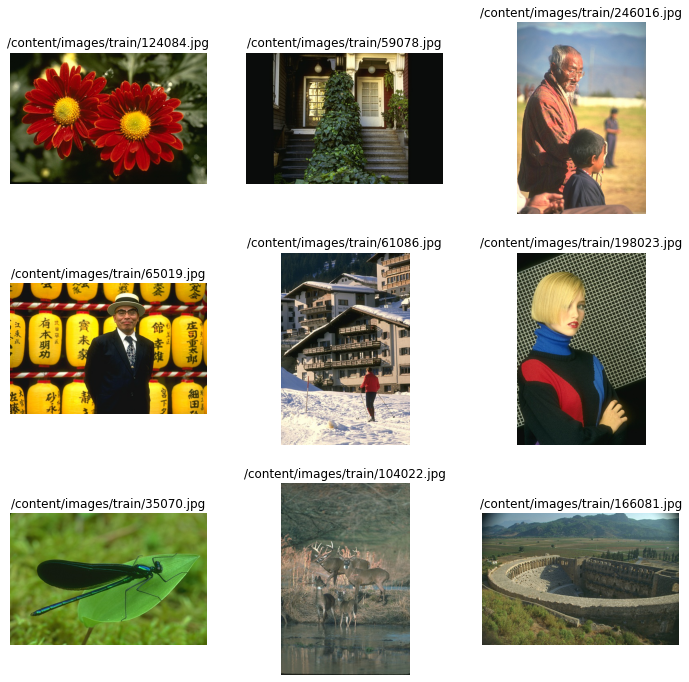

In [7]:
# 예제 9.20 : 이미지 확인
import PIL.Image as Image
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 12))
for c in range(9):
  plt.subplot(3, 3, c + 1)
  plt.imshow(plt.imread(all_image_paths[c]))
  plt.title(all_image_paths[c])
  plt.axis('off')
plt.show()

In [0]:
# 예제 9.21 : 이미지 경로 분리 저장
train_path, valid_path, test_path = [], [], []

for image_path in all_image_paths:
  if str(image_path).split('.')[-1] != 'jpg':
    continue

  if str(image_path).split('/')[-2] == 'train':
    train_path.append(str(image_path))
  elif str(image_path).split('/')[-2] == 'val':
    valid_path.append(str(image_path))
  else:
    test_path.append(str(image_path))

In [0]:
# 예제 9.22 : 원본 이미지에서 조각을 추출하고 입력, 출력 데이터를 반환하는 함수 정의
def get_hr_and_lr(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels = 3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  hr = tf.image.random_crop(img, [50, 50, 3])
  lr = tf.image.resize(hr, [25, 25])
  lr = tf.image.resize(lr, [50, 50])

  return lr, hr

In [0]:
# 예제 9.23 : train, valid Dataset 정의
train_dataset = tf.data.Dataset.list_files(train_path)
train_dataset = train_dataset.map(get_hr_and_lr)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(16)

valid_dataset = tf.data.Dataset.list_files(valid_path)
valid_dataset = valid_dataset.map(get_hr_and_lr)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(1)

In [0]:
# 예제 9.24 : tf.keras의 함수형 API를 사용한 REDNet 네트워크 정의
def REDNet(num_layers):
  conv_layers = []
  deconv_layers = []
  residual_layers = []

  inputs = tf.keras.layers.Input(shape = (None, None, 3))
  conv_layers.append(tf.keras.layers.Conv2D(3, kernel_size = 3, padding = 'same', activation = 'relu'))

  for i in range(num_layers - 1):
    conv_layers.append(tf.keras.layers.Conv2D(64, kernel_size = 3, padding = 'same', activation = 'relu'))
    deconv_layers.append(tf.keras.layers.Conv2DTranspose(64, kernel_size = 3, padding = 'same', activation = 'relu'))
  
  deconv_layers.append(tf.keras.layers.Conv2DTranspose(3, kernel_size = 3, padding = 'same'))

  # 인코더 시작
  x = conv_layers[0](inputs)

  for i in range(num_layers - 1):
    x = conv_layers[i + 1](x)

    if i % 2 == 0:
      residual_layers.append(x)

  # 디코더 시작
  for i in range(num_layers - 1):
    if i % 2 == 1:
      x = tf.keras.layers.Add()([x, residual_layers.pop()])
      x = tf.keras.layers.Activation('relu')(x)
    x = deconv_layers[i](x)

  x = deconv_layers[-1](x)

  model = tf.keras.Model(inputs = inputs, outputs = x)

  return model

In [0]:
# 예제 9.25 : PSNR 정의
def psnr_metric(y_true, y_pred):
  return tf.image.psnr(y_true, y_pred, max_val = 1.0)

In [0]:
# 예제 9.26 : REDNet-30 네트워크 초기화 및 컴파일
model = REDNet(15)
model.compile(optimizer = tf.optimizers.Adam(0.0001), loss = 'mse', metrics = [psnr_metric])

# 네트워크 시각화
# tf.keras.utils.plot_model(model)

In [14]:
# 예제 9.27 : REDNet-30 네트워크 학습
history = model.fit_generator(train_dataset, epochs = 1000, steps_per_epoch = len(train_path) // 16,
                              validation_data = valid_dataset, validation_steps = len(valid_path),
                              verbose = 2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/1000
12/12 - 2s - loss: 0.1724 - psnr_metric: 9.3496 - val_loss: 0.0610 - val_psnr_metric: 13.4501
Epoch 2/1000
12/12 - 2s - loss: 0.0377 - psnr_metric: 15.6093 - val_loss: 0.0223 - val_psnr_metric: 17.6434
Epoch 3/1000
12/12 - 2s - loss: 0.0250 - psnr_metric: 17.2215 - val_loss: 0.0218 - val_psnr_metric: 17.6671
Epoch 4/1000
12/12 - 2s - loss: 0.0216 - psnr_metric: 17.8068 - val_loss: 0.0160 - val_psnr_metric: 19.0853
Epoch 5/1000
12/12 - 2s - loss: 0.0179 - psnr_metric: 18.5727 - val_loss: 0.0160 - val_psnr_metric: 18.8532
Epoch 6/1000
12/12 - 2s - loss: 0.0154 - psnr_metric: 19.2882 - val_loss: 0.0122 - val_psnr_metric: 20.3901
Epoch 7/1000
12/12 - 2s - loss: 0.0127 - psnr_metric: 19.9007 - val_loss: 0.0106 - val_psnr_metric: 20.7238
Epoch 8/1000
12/12 - 2s - loss: 0.0118 - psnr_metric: 20.6041 - val_loss: 0.0089 - val_psnr_metric: 21.9687
Epoch 9/1000
12/12 - 2s - loss: 0.0102 - psnr_metric: 21.3834

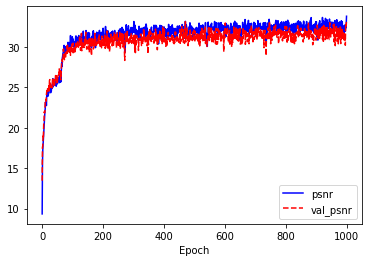

In [15]:
# 예제 9.28 : REDNet-30 네트워크 학습 결과 확인
import matplotlib.pyplot as plt
plt.plot(history.history['psnr_metric'], 'b-', label = 'psnr')
plt.plot(history.history['val_psnr_metric'], 'r--', label = 'val_psnr')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [18]:
# 예제 9.29 : test 이미지에 대한 초해상도
import numpy as np

img = tf.io.read_file(test_path[0])
img = tf.image.decode_jpeg(img, channels = 3)
hr = tf.image.convert_image_dtype(img, tf.float32)

lr = tf.image.resize(hr, [hr.shape[0] // 2, hr.shape[1] // 2])
lr = tf.image.resize(lr, [hr.shape[0], hr.shape[1]])
predict_hr = model.predict(np.expand_dims(lr, axis = 0))

print(tf.image.psnr(np.squeeze(predict_hr, axis = 0), hr, max_val = 1.0))
print(tf.image.psnr(lr, hr, max_val = 1.0))

tf.Tensor(32.715473, shape=(), dtype=float32)
tf.Tensor(32.398766, shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


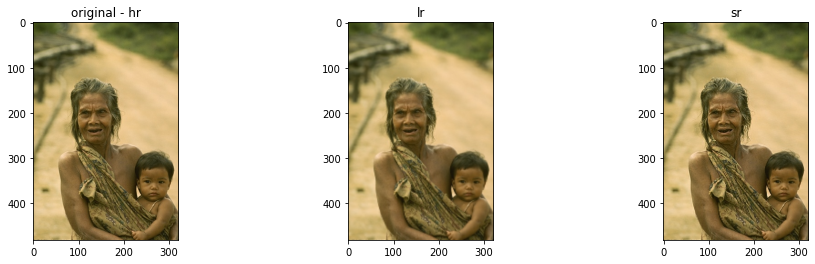

In [19]:
# 예제 9.30 : test 이미지에 대한 초해상도 결과 확인
plt.figure(figsize = (16, 4))

plt.subplot(1, 3, 1)
plt.imshow(hr)
plt.title('original - hr')

plt.subplot(1, 3, 2)
plt.imshow(lr)
plt.title('lr')

plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(predict_hr, axis = 0))
plt.title('sr')

plt.show()

131072/127529 [==============================] - 0s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(30.824537, shape=(), dtype=float32)
tf.Tensor(24.783773, shape=(), dtype=float32)


Text(0.5, 1.0, 'sr')

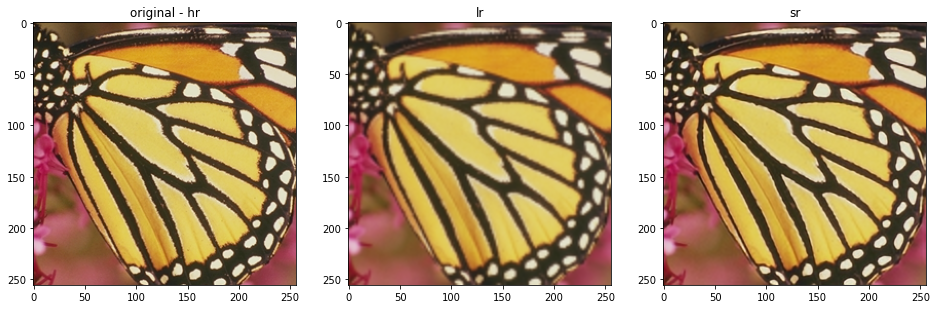

In [20]:
# 예제 9.31 : Set5의 나비 이미지 테스트
image_path = tf.keras.utils.get_file('butterfly.png', 'http://bit.ly/2oAOxgH')
img = tf.io.read_file(image_path)
img = tf.image.decode_jpeg(img, channels = 3)
hr = tf.image.convert_image_dtype(img, tf.float32)

lr = tf.image.resize(hr, [hr.shape[0] // 2, hr.shape[1] // 2])
lr = tf.image.resize(lr, [hr.shape[0], hr.shape[1]])
predict_hr = model.predict(np.expand_dims(lr, axis = 0))

print(tf.image.psnr(np.squeeze(predict_hr, axis = 0), hr, max_val = 1.0))
print(tf.image.psnr(lr, hr, max_val = 1.0))

plt.figure(figsize = (16, 6))
plt.subplot(1, 3, 1)
plt.imshow(hr)
plt.title('original - hr')

plt.subplot(1, 3, 2)
plt.imshow(lr)
plt.title('lr')

plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(predict_hr, axis = 0))
plt.title('sr')

In [0]:
# 예제 9.32 : 확대 비율을 2배에서 4배로 수정, 이미지 보강
import random
def get_hr_and_lr_flip_s4(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels = 3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  hr = tf.image.random_crop(img, [50, 50, 3])
  lr = tf.image.resize(hr, [12, 12])
  lr = tf.image.resize(lr, [50, 50])

  if random.random() < 0.25:
    hr = tf.image.flip_left_right(hr)
    lr = tf.image.flip_left_right(lr)
  
  if random.random() < 0.25:
    hr = tf.image.flip_up_down(hr)
    lr = tf.image.flip_up_down(lr)

  return lr, hr

In [22]:
# 예제 9.33 : REDNet - 30 네트워크 학습
train_dataset = tf.data.Dataset.list_files(train_path)
train_dataset = train_dataset.map(get_hr_and_lr_flip_s4)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(16)

valid_dataset = tf.data.Dataset.list_files(valid_path)
valid_dataset = valid_dataset.map(get_hr_and_lr_flip_s4)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(1)

model = REDNet(15)
model.compile(optimizer = tf.optimizers.Adam(0.0001), loss = 'mse', metrics = [psnr_metric])

history = model.fit_generator(train_dataset, 
                              epochs = 250,
                              steps_per_epoch = len(train_path) // 16,
                              validation_data = valid_dataset,
                              validation_steps = len(valid_path),
                              verbose = 2)

Epoch 1/250
12/12 - 2s - loss: 0.0988 - psnr_metric: 12.0744 - val_loss: 0.0431 - val_psnr_metric: 14.8988
Epoch 2/250
12/12 - 2s - loss: 0.0295 - psnr_metric: 16.3888 - val_loss: 0.0239 - val_psnr_metric: 16.9867
Epoch 3/250
12/12 - 2s - loss: 0.0218 - psnr_metric: 17.5353 - val_loss: 0.0205 - val_psnr_metric: 17.6914
Epoch 4/250
12/12 - 2s - loss: 0.0187 - psnr_metric: 18.2130 - val_loss: 0.0168 - val_psnr_metric: 18.6096
Epoch 5/250
12/12 - 2s - loss: 0.0163 - psnr_metric: 19.0037 - val_loss: 0.0144 - val_psnr_metric: 19.7070
Epoch 6/250
12/12 - 2s - loss: 0.0157 - psnr_metric: 19.2634 - val_loss: 0.0125 - val_psnr_metric: 20.1115
Epoch 7/250
12/12 - 2s - loss: 0.0129 - psnr_metric: 20.2021 - val_loss: 0.0105 - val_psnr_metric: 20.8838
Epoch 8/250
12/12 - 2s - loss: 0.0107 - psnr_metric: 21.0881 - val_loss: 0.0118 - val_psnr_metric: 20.8907
Epoch 9/250
12/12 - 2s - loss: 0.0107 - psnr_metric: 21.2749 - val_loss: 0.0089 - val_psnr_metric: 21.6147
Epoch 10/250
12/12 - 2s - loss: 0.010

In [23]:
# 예제 9.34 : Set5 이미지 불러오기
image_path = tf.keras.utils.get_file("/content/Set5.zip", 'http://bit.ly/2MEG4kr')
!unzip Set5.zip

860160/852576 [==============================] - 0s 0us/step
Archive:  Set5.zip
   creating: Set5/
 extracting: Set5/baby.png           
 extracting: Set5/bird.png           
 extracting: Set5/butterfly.png      
 extracting: Set5/head.png           
  inflating: Set5/woman.png          


In [25]:
# 예제 9.35 : Set5 이미지의 PSNR 점수 확인
set5_image_root = pathlib.Path('/content/Set5')
set5_image_paths = list(set5_image_root.glob('*.*'))

sr_psnr = []
lr_psnr = []

for image_path in set5_image_paths:
  img = tf.io.read_file(str(image_path))
  img = tf.image.decode_jpeg(img, channels = 3)
  hr = tf.image.convert_image_dtype(img, tf.float32)
  lr = tf.image.resize(hr, [hr.shape[0] // 4, hr.shape[1] // 4])
  lr = tf.image.resize(lr, [hr.shape[0], hr.shape[1]])
  predict_hr = model.predict(np.expand_dims(lr, axis = 0))

  sr_psnr.append(tf.image.psnr(np.squeeze(predict_hr, axis = 0), hr, max_val = 1.0).numpy())
  lr_psnr.append(tf.image.psnr(lr, hr, max_val = 1.0).numpy())

print('sr :', sr_psnr)
print('sr_mean :', np.mean(sr_psnr))
print()
print('lr :', lr_psnr)
print('lr mean :', np.mean(lr_psnr))

sr : [28.362505, 26.358356, 29.698044, 24.814783, 20.845268]
sr_mean : 26.015789

lr : [28.569517, 27.31659, 29.72251, 24.495182, 20.217585]
lr mean : 26.06428
